Machine used - Paperspace Gradient Free
    <br>CPU Intel Xeon 8 vCPUs 2.60 GHz Host memory 30 GB
    <br>GPU 8 GB Quadro M4000

In [ ]:
# New
# Models and scores
# Total no of submissions this competition has got is 5558
#           Private   Public   Private_Rank   In_top%
# ML models
# 'M0.1' :  5.09      5.16
# 'M0.2' :  2.67      2.84

# 'M3.1' :  0.91      0.86     1980         35.62%
# 'M3.2' :  0.91      0.94
# 'M3.3' :  0.85      0.91
# 'M3.4' :  0.89      0.94
# 'M3.5' :  0.94      0.86
# 'M3.6' :  0.87      0.88

# 'M4.1' :  4.90      4.99
# 'M4.2' :  4.90      5.29

# 'M5.1' :  0.84      1.26      
# 'M5.2' :  0.95      1.11
# 'M5.3' :  5.05      4.93

# 'M7.1' :  0.73      0.92      757          13.62%
# 'M7.2' :  0.94      1.08      2150         37.78%


# Neural network models
# NN M3  :  1.12      0.99
# NN M4  :  0.82      1.21      1933         34%
# NN M5  :  1.90      1.70
# NN M6  :  3.58      4.30

## Fetching Data, Imports, Load CSV

In [1]:
# !wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en-GB;q=0.9,en-US;q=0.8,en;q=0.7" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/18599/1236839/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605342864&Signature=EnlHY9DVWLCrCG3Pq5%2BgOpZ5ci%2Bl%2FKz0BEsVVDVArUb9SJLMH24iEQ%2FwF3dELdUj1IoUWxhz7%2BRUaMJDLEoMfoHH28pWgcH0BpHwpC6ODo9dgw8gT5rEJJ%2FerJQW7ALQHxRT2OlMDjYgKZuqlO0D53K9iUjqbHcRwNTR0aOlAyB7coNuJfVfUOCyQhksene0O1rNi4FlUOpSLWcbe9IogPeeOGDLFGmdiS1wHVo4H5cVrNgcuehj8PcSTLZU9UbE7oHRacs8jUz7CKUPU3NgEQ76eWcvb%2Bu46rBWJvu%2BD51fq%2BX0me7ysMizf0HQ7xLoTLTqc7loAqaaW3hEy3k5sw%3D%3D&response-content-disposition=attachment%3B+filename%3Dm5-forecasting-accuracy.zip" -c -O 'm5-forecasting-accuracy.zip'

In [5]:
# !unzip m5-forecasting-accuracy.zip

# !apt-get update
# !apt-get install wget

# ! pip install pandas
# ! pip install calender
# ! pip install numpy
# ! pip install datetime
# ! pip install matplotlib
# ! pip install collections
# ! pip install random
# ! pip install tqdm
# ! pip install sklearn
# ! pip install lightgbm

In [1]:
from IPython.display import clear_output 
import pandas as pd
import calendar
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output as cclear
from sklearn.metrics import mean_squared_error as mse
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer
import lightgbm as lgb
from math import sqrt
from itertools import zip_longest
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randFloat
import joblib
import xgboost as xgb

def get_csv(X):
    return pd.read_csv(X)

calender, sales_train_ev, sales_train_val, sell_prices, samp_sub = get_csv('calendar.csv'), \
                          get_csv('sales_train_evaluation.csv'), \
                          get_csv('sales_train_validation.csv'), get_csv('sell_prices.csv'), \
                          get_csv('sample_submission.csv')

## Training Functions

In [ ]:
# (1941-28), (1941-28-28), (1941-28-28-28)
# 1858 [56619930] to 1885 [57446208]
# 1886 [57446209] to 1913 [58299928]
# 1914 [58299929] to 1941 [59153648]

# X_train = X.iloc[0:(3049*1857)]
# X_test = X.iloc[(3049*1857):(3049*1885)]

# X_train = X.iloc[0:(3049*1885)]
# X_test = X.iloc[(3049*1885):(3049*1913)]

# X_train = X.iloc[0:(3049*1913)]
# X_test = X.iloc[(3049*1913):]

In [2]:
non_numeric_col_list = ['id','item_id','dept_id','cat_id','store_id','state_id','d', 'date']
store_dict = {'CA_1':0, 'CA_2':0, 'CA_3':0, 'CA_4':0, 'WI_1':0, 'WI_2':0, 'WI_3':0, 'TX_1':0, 'TX_2':0, 'TX_3':0}


# This function does feature engineering on sales_train_ev or sales_train_val
# There is another feature engineering function for adding columns to dataframe containing rows of only onw store
def feature_engineer(df):
    day_columns = list(df.columns[6:])
    other_var = list(df.columns[:6])
    
    print('Melting out...')
    df = pd.melt(df, id_vars = other_var, value_vars = day_columns)
    df = df.rename(columns = {"variable": "d", "value": "unit_sale"})
    # print(df.shape)
    
    print('Adding Feature \'date\'...')
    cal_dict = dict(zip(calender.d,calender.date))
    df["date"] = df["d"].map(cal_dict)
    # df.head()
    
    print('Adding Feature \'day_of_week\'...')
    day_of_week_dict = dict(zip(calender.d,calender.wday))
    df['day_of_week'] = df["d"].map(day_of_week_dict)

    print('Adding Feature \'month_no\'...')
    month_no_dict = dict(zip(calender.d,calender.month))
    df['month_no'] = df["d"].map(month_no_dict)
    
    print('Adding Feature \'day_of_month\'...')
    l = [i[-2:] for i in list(calender.date)]
    calender['day_of_month'] = l
    
    day_of_month_dict = dict(zip(calender.d,calender.day_of_month))
    df['day_of_month'] = df["d"].map(day_of_month_dict)
    
    print('Done.')
    return df

def add_moving_avg_col(new_df,N, col_name):
    l = np.convolve(list(new_df[col_name]), np.ones((N,))/N, mode='valid')
    nl = [0]*(N-1)
    nl.extend(list(l))
    new_df[str(N)+'_d_mavg_'+str(col_name)] = nl
    return new_df


def event1_check(index):
    # Input is 0 to 1968, it is the index of Calender.CSV
    # Output is True if there is event 1, False if no event 1
    return not(calender.event_name_1[index] != calender.event_name_1[index])

def event2_check(index):
    # Input is 0 to 1968, it is the index of Calender.CSV
    # Output is True if there is event 2, False if no event 2
    return not(calender.event_name_2[index] != calender.event_name_2[index])

days_with_event = []
for i in range(len(calender)):
    days_with_event.append(event1_check(i)) or (event2_check(i))
    
l = [int(i) for i in days_with_event]
event_dict = dict(zip(calender.d, l))

week_no_d_dict = dict(zip(calender.wm_yr_wk, calender.d))
sell_prices['d'] = sell_prices['wm_yr_wk'].map(week_no_d_dict)
sell_prices['item_d_col'] = sell_prices['item_id'] + sell_prices['d']
sale_price_dict = dict(zip(sell_prices['item_d_col'], sell_prices['sell_price']))

sell_prices = sell_prices.drop('d', 1)
sell_prices = sell_prices.drop('item_d_col', 1)


def one_feature_engineering_fun(df):
    snap_dict = dict(zip(calender.d, calender['snap_'+df.state_id.iloc[0]]))   # Add snap or not column
    df['snap_or_not'] = df["d"].map(snap_dict)
    print('snap added')
    
    df['event_or_not'] = df["d"].map(event_dict)    # Adding event or not column
    print('events added')
    
    df['item_d_col'] = df['item_id'] + df['d']      # Adding sale_price column
    df['sale_price'] = df['item_d_col'].map(sale_price_dict)
    df['sale_price'] = df['sale_price'].fillna(0)
    print('sale prices added')
    
    df = df.drop('item_d_col', 1)                   # Undoing the columns we had to add
    
    df['Total_sale'] = df.unit_sale * df.sale_price  # Adding total sale column
    
    df = add_moving_avg_col(df,7, 'sale_price')     # Adding moving averages for sale price
    df = add_moving_avg_col(df,14, 'sale_price')
    df = add_moving_avg_col(df,30, 'sale_price')
    df = add_moving_avg_col(df,60, 'sale_price')
    df = add_moving_avg_col(df,180, 'sale_price')
                 
    df['day_of_month'] = df['day_of_month'].fillna(0)
    df = df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
    
    df['date'] = df['date'].astype(str)
    
    df = add_moving_avg_col(df,7, 'unit_sale')     # Adding moving average columns
    df = add_moving_avg_col(df,14, 'unit_sale')
    df = add_moving_avg_col(df,30, 'unit_sale')
    df = add_moving_avg_col(df,60, 'unit_sale')
    df = add_moving_avg_col(df,180, 'unit_sale')
    print('Total sale and Unit sale moving averages added')
    
    l1 = df.day_of_week == 1                       # we are adding an weekend or not column
    l2 = df.day_of_week == 2

    l1 = np.logical_or(l1,l2)
    l1 = [elem*1 for elem in l1]
    df['weekend'] = l1
    print('Weekends added')
    
    return df


def encode_cat_cols(new_df):
    le = [0]*len(non_numeric_col_list)             # Encoding Categorical Columns
    for i in range(len(non_numeric_col_list)):
        print("Encoding col: ", non_numeric_col_list[i])
        le[i] = LabelEncoder()
        new_df[non_numeric_col_list[i]] = le[i].fit_transform( new_df[non_numeric_col_list[i]] )
    return le, new_df

# This function takes sales_train_ev or sales_train_val after feature_engineer() function has been called on them
# and returns X, y and labelencoder after adding few more columns and encoding categorical features.
def get_X_and_y(df, store_name):               
    print('Store Name:', store_name)
    new_df = df[df.store_id == store_name]        # Selecting rows for the selected store
    
    print('Store rows picked now working on adding columns...')
    new_df = one_feature_engineering_fun(new_df)     # working on adding more columns and changing datatype of columns
    
    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)
    
    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df
    
    return X, y, le

# This function gets X and y but doesnt add any more features than already added in feature_engineer()
def get_X_and_y_withou_adding_more_features(df, store_name):               
    print('Store Name:', store_name)
    new_df = df[df.store_id == store_name]        # Selecting rows for the selected store
    
    new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
    new_df = new_df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
    new_df['date'] = new_df['date'].astype(str)
    
    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)
    
    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df
    
    return X, y, le


# Functions in below this are used to change to data back to previuos form undoing long-form

# This function can be called to get prediction and mse for one single store
def mse_and_out_df(df, store_name):  # df is either sales_train_ev or sales_train_val. Store name in one of 10 stores.
    le, X_test, y_test, train_out = fit_fun_2(df, store_name)
    train_rmse = sqrt(mse(y_test, train_out))
    out_df = reverse_long_form(le, X_test, train_out)
    
    return train_rmse, out_df

# def training_function(df):
#     main_out_df = pd.DataFrame()
#     _, out_df1 = mse_and_out_df(df, 'CA_1')
#     _, out_df2 = mse_and_out_df(df, 'CA_2')
#     _, out_df3 = mse_and_out_df(df, 'CA_3')
#     _, out_df4 = mse_and_out_df(df, 'CA_4')

#     _, out_df5 = mse_and_out_df(df, 'WI_1')
#     _, out_df6 = mse_and_out_df(df, 'WI_2')
#     _, out_df7 = mse_and_out_df(df, 'WI_3')

#     _, out_df8 = mse_and_out_df(df, 'TX_1')
#     _, out_df9 = mse_and_out_df(df, 'TX_2')
#     _, out_df10 = mse_and_out_df(df, 'TX_3')
    
#     main_out_df = pd.concat([main_out_df, out_df1], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df2], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df3], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df4], ignore_index=False)

#     main_out_df = pd.concat([main_out_df, out_df5], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df6], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df7], ignore_index=False)

#     main_out_df = pd.concat([main_out_df, out_df8], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df9], ignore_index=False)
#     main_out_df = pd.concat([main_out_df, out_df10], ignore_index=False)
    
#     l = []      # In this part we rename the columns to F_1, F_2 ....
#     for i in range(1,29):
#         l.append('F'+str(i))
#     l = ['id']+l

#     main_out_df.columns = l
#     return main_out_df

def training_function(df):
    main_out_df = pd.DataFrame()
    
    for i in list(set(df.store_id)):
        _, interm_df = mse_and_out_df(df, i)
        main_out_df = pd.concat([main_out_df, interm_df], ignore_index=False)
    
    l = []      # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    l = ['id']+l

    main_out_df.columns = l
    return main_out_df


# Function for reversing the long form
def reverse_long_form(le, X_test, train_out):
    for i in range(len(non_numeric_col_list)):
        X_test[non_numeric_col_list[i]] = le[i].inverse_transform(X_test[non_numeric_col_list[i]])

    X_test['unit_sale'] = train_out
    kk = X_test.pivot(index='id', columns='d')['unit_sale']
    kk['id'] = kk.index
    kk.reset_index(drop=True, inplace=True)

    cols = list(kk)
    cols = [cols[-1]] + cols[:-1]
    kk = kk[cols]

    return kk

def reorder_data(df, csv_name):
    df['sp_index'] = (df.index)
    index_dict = dict(zip(df.id, df.sp_index))
    df = df.drop('sp_index', axis=1)

    kk = pd.read_csv(str(csv_name)+'.csv')
    kk = kk.drop(kk.columns[0], axis=1)

    kk['sp_index'] = kk["id"].map(index_dict)
    kk = kk.sort_values(by='sp_index', axis=0)
    kk = kk.drop('sp_index', axis=1)
    kk.to_csv(str(csv_name)+'.csv')

In [3]:
# This function takes output of fit_fun_2(), the output named out_df and plots prediction vs true label for 
# given item id. However, for sales_train_ev we need to change fit_fun_2() to have prediction on 1913 to 1969 
# to see prediction and true label on 1913 to 1941 bcs there is no true label for 1942 to 1969.

def plot_prediction(out_df, item_id, multiply_prediction_by):
    ll = list(out_df[out_df.id == item_id].iloc[0].iloc[1:])
    ll = [elem*multiply_prediction_by for elem in ll]
    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)
    plt.plot(ll)
    plt.plot(sales_train_ev[sales_train_ev.id == item_id].iloc[0].iloc[1919:])
    plt.legend(['predict', 'original'])
    plt.title(str(item_id)+'prediction, prediction * '+ str(multiply_prediction_by))
    plt.xlabel('Days from 1914 to 1941')
    plt.ylabel('No of units sold')

    plt.subplot(1,2,2)
    ll = list(out_df[out_df.id == item_id].iloc[0].iloc[29:])
    ll = [elem*multiply_prediction_by for elem in ll]
    plt.plot(ll)
    plt.title(str(item_id)+'prediction, prediction * '+str(multiply_prediction_by))
    plt.xlabel('Days from 1942 to 1969')
    plt.ylabel('No of units sold')

## Hyperparameter Tuning

### Hyperparameter Tuning - 1

In this tuning strategy we do hyperparameter tuning for entire data and add all the features we can.

In [ ]:
%%time
df = feature_engineer(sales_train_ev)

print('Store Name:', 'CA_1')
new_df = df[df.store_id == 'CA_1']        # Selecting rows for the selected store

print('Store rows picked now working on adding columns...')
new_df = one_feature_engineering_fun(new_df)     # working on adding more columns and changing datatype of columns

y = new_df.unit_sale                          # getting the label
new_df = new_df.drop('unit_sale', axis=1)

print('Encoding categorical features...')
le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

X = new_df

X_train, y_train = X.iloc[0:3049*1913], y[:3049*1913]
X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]

param_list_to_try = {'num_leaves': sp_randint(500, 1000),
            'learning_rate':sp_randFloat(0.01, 0.9),
            'reg_lambda':sp_randFloat(0.1, 0.9),
            'min_data_in_leaf': sp_randint(500, 1000),
            'n_estimators':sp_randint(100, 1200)}

no_of_hyperparameters = 3
clf = LGBMRegressor(objective = 'tweedie', metric='None')

random_search = RandomizedSearchCV( estimator = clf, param_distributions = param_list_to_try,\
                                   n_iter = no_of_hyperparameters\
            ,scoring = make_scorer(mse, greater_is_better = False), cv = 2, refit = True, \
                                   random_state = 314, verbose = True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

In [ ]:
# Best score reached: -15.426872694657348 with params: \
# with objective tweedie
# {'learning_rate': 0.6790495589419234, 'min_data_in_leaf': 906, 'n_estimators': 363, 'num_leaves': 588, 'reg_lambda': 0.7897384208694526} 

### Hyperparameter Tuning - 2

Here we add all the columns and do hyperparameter tuning on only one year of data.

In [ ]:
%%time
df = feature_engineer(sales_train_ev)

print('Store Name:', 'CA_1')
new_df = df[df.store_id == 'CA_1']        # Selecting rows for the selected store

print('Store rows picked now working on adding columns...')
new_df = one_feature_engineering_fun(new_df)     # working on adding more columns and changing datatype of columns

y = new_df.unit_sale                          # getting the label
new_df = new_df.drop('unit_sale', axis=1)

print('Encoding categorical features...')
le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

X = new_df

X_train, y_train = X.iloc[3049*(1941-365):3049*1941], y[3049*(1941-365):3049*1941]
X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

param_list_to_try = {'num_leaves': sp_randint(500, 1500),
            'learning_rate':sp_randFloat(0.01, 0.9),
            'reg_lambda':sp_randFloat(0.1, 0.9),
            'min_data_in_leaf': sp_randint(500, 1500),
            'n_estimators':sp_randint(100, 1500)}

no_of_hyperparameters = 3
clf = LGBMRegressor(objective = 'tweedie', metric='None')

random_search = RandomizedSearchCV( estimator = clf, param_distributions = param_list_to_try,\
                                   n_iter = no_of_hyperparameters\
            ,scoring = make_scorer(mse, greater_is_better = False), cv = 2, refit = True, \
                                   random_state = 314, verbose = True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

In [ ]:
# Best score reached: -10.332310348102666 with params: 
# {'learning_rate': 0.6790495589419234, 'min_data_in_leaf': 1418, 'n_estimators': 363, 'num_leaves': 1100, 
# 'reg_lambda': 0.7897384208694526} 

### Hyperparameter Tuning - 3

Here we do not add any column after initial feature_engineer() function. We use data of one year only.

In [ ]:
%%time
df = feature_engineer(sales_train_ev)

X, y, le = get_X_and_y_withou_adding_more_features(df, 'CA_1')

X_train, y_train = X.iloc[3049*(1941-365):3049*1941], y[3049*(1941-365):3049*1941]
X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

param_list_to_try = {'num_leaves': sp_randint(500, 1500),
            'learning_rate':sp_randFloat(0.01, 0.9),
            'reg_lambda':sp_randFloat(0.1, 0.9),
            'min_data_in_leaf': sp_randint(500, 1500),
            'n_estimators':sp_randint(100, 1500)}

no_of_hyperparameters = 3
clf = LGBMRegressor(objective = 'tweedie', metric='None')

random_search = RandomizedSearchCV( estimator = clf, param_distributions = param_list_to_try,\
                                   n_iter = no_of_hyperparameters\
            ,scoring = make_scorer(mse, greater_is_better = False), cv = 2, refit = True, \
                                   random_state = 314, verbose = True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

In [ ]:
# Best score reached: -12.192196035052088 with params: 
# {'learning_rate': 0.6790495589419234, 'min_data_in_leaf': 1418, 'n_estimators': 363, 'num_leaves': 1100, 
# 'reg_lambda': 0.7897384208694526}

## Different Training Strategies

### Words on Train Test Split

We want to predict 28 days under labels F1-F28. These 28 days are like this for evaluation and validation dataset.
<br>For evaluation dataset predict d_1942 - d_1969
<br>For validation dataset predict d_1914 - d_1941

### Training strategy 0.1

In [ ]:
# First score is Private and second score is Public score

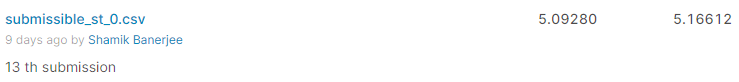

In this strategy we train on one year data only, so for eval data we train on 1941-365 to 1941 and for val data we train on 1913-365 to 1913 test on 1941 to 1969 for evaluation data and we test on 1913 to 1941 for validation data. 

However we use four models to predict 28 days. First model predicts week1, second predicts week1 and week2, third predicts week1, week2, week3 and fourth model predicts week1, week2, week3, week4. Then we append 0 s to make all these predicted lists same length and then we take element wise mean to make the final prediction.

Though a good concept, it did not do well during submission.

In [4]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, \
                                                                3049*(1913-365), 3049*1913
strategy = 0.1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name) # this fun selects rows for given store name, adds more columns, 
                                           # does encoding, returns X and y and encoder

    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        # for plotting prediction
        # X_train, y_train = X.iloc[3049*(1913-365):3049*1913], y[3049*(1913-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]
        
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model = [0]*4
    for i in range(4):
        model[i] = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)

    print("One of 4 models fitting....")
    model[0].fit(X_train, y_train)
    train_out_week1 = model[0].predict(X_test.iloc[(0*3049):(7*3049)])
    
    print("Two of 4 models fitting....")
    model[1].fit(X_train, y_train)
    train_out_week12 = model[1].predict(X_test.iloc[(0*3049):(14*3049)])
    
    print("Three of 4 models fitting....")
    model[2].fit(X_train, y_train)
    train_out_week123 = model[2].predict(X_test.iloc[(0*3049):(21*3049)])
    
    print("Four of 4 models fitting....")
    model[3].fit(X_train, y_train)
    train_out_week1234 = model[3].predict(X_test.iloc[(0*3049):(28*3049)])
    
    train_out = [np.mean(n) for n in zip_longest(train_out_week1, train_out_week12, train_out_week123, train_out_week1234\
                                          , fillvalue=0)]
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [12]:
# %%time

# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, \
#                                                                 _, _
# strategy = 0.1

# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)
# out_df.head(5)

# ########################################################################################################################
# # 4 min

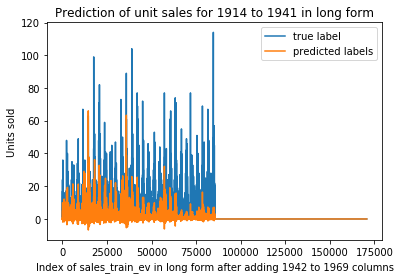

In [17]:
plt.plot(list(y_test))
plt.plot(list(train_out))
plt.legend(['true label', 'predicted labels'])
plt.title('Prediction of unit sales for 1914 to 1941 in long form')
plt.xlabel('Index of sales_train_ev in long form after adding 1942 to 1969 columns')
plt.ylabel("Units sold")
plt.show()

### Training strategy 0.2

In [ ]:
# First score is Private and second score is Public score

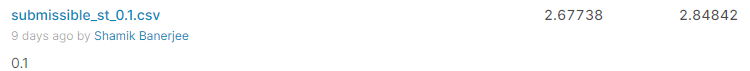

We do not test code for this one as only differece from 0.1 model is that this one fits entire val data
and previous one took only one year of val data.

In [19]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 0.1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y_withou_adding_more_features(df, store_name)

    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        # for plotting prediction
        # X_train, y_train = X.iloc[3049*(1913-365):3049*1913], y[3049*(1913-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]
        
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model = [0]*4
    for i in range(4):
        model[i] = LGBMRegressor(num_leaves=1100, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 1418)

    model[0].fit(X_train, y_train)
    train_out_week1 = model[0].predict(X_test.iloc[(0*3049):(7*3049)])
    
    model[1].fit(X_train, y_train)
    train_out_week12 = model[1].predict(X_test.iloc[(0*3049):(14*3049)])
    
    model[2].fit(X_train, y_train)
    train_out_week123 = model[2].predict(X_test.iloc[(0*3049):(21*3049)])
    
    model[3].fit(X_train, y_train)
    train_out_week1234 = model[3].predict(X_test.iloc[(0*3049):(28*3049)])
    
    train_out = [np.mean(n) for n in zip_longest(train_out_week1, train_out_week12, train_out_week123, train_out_week1234\
                                          , fillvalue=0)]
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# %%time

# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, \
#                                                                 _, _
# strategy = 0.1

# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)
# out_df.head(5)

##################################################################################################################
# 4 min


### Training strategy 1 - Ignore

As it is very complex, this one could not be run on my machine. So we move on to second simpler method.
This one should be ignored.

Training strategy used in fit_fun_2():
<br>Train on data till 1829, predict on X_test of 1829 to 1857. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

This is repeated for next test sets as described below.

Train on data till 1857, predict on X_test of 1858 to 1885. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data.This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1885, predict on X_test of 1886 to 1913. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data.This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1913, predict on X_test of 1914 to 1941. Now for this prediction we will use 4 models, each model will predict one week of the 28 days of test data. This prediction is ultimate prediction for this store.

change: we kept only last two stages in code, only 1886 to 1913 and 1913 to 1941, but it could not be run.

In [ ]:
# This function takes input which year to which year should be test data and returns extended y_train or train_out 
# as necessary.

def year_wise_train_test(X, y, y_train, start, end):
    X_train, X_test = X.iloc[0:(3049*start)], X.iloc[(3049*start):(3049*end)] 
    y_test = y[(3049*start):(3049*end)]

    if y_train==1:
        y_train = y[0:(3049*start)]
        
    train_out = []
    for i in range(4):
        print('Predicting week ', i)
        model = LGBMRegressor(objective = 'tweedie', num_leaves=588, learning_rate=0.67, reg_lambda=0.78, \
                              n_estimators= 363, min_data_in_leaf= 906)
        model.fit(X_train, y_train)
        train_out.extend(list( model.predict(X_test.iloc[(i*7*3049):((i+1)*7*3049)] )))
    
    y_train = list(y_train)
    
    if (start == 1913) and (end==1941):
        return y_train, X_test, y_test, train_out
    else:    
        y_train.extend(list(train_out))
        return y_train
strategy = 1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    print('Testing on 1885 to 1913...')
    y_train = year_wise_train_test(X, y, 1, 1885, 1913)
    
    print('Testing on 1913 to 1941...')
    y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, 1913, 1941)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        print('Testing on 1941 to 1969...')
        y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, 1941, 1969)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
# %%time
# df = sales_train_ev.copy()  # estimated 37 seconds to run
# df = feature_engineer(df)

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# mse(train_out, y_test)
########################################################################################################################

### Training strategy 2 - Ignore

This method is fairly complex, it did well while training but submission scores were extremely bad.
As this method predicts on prediction I am moving forward to other methods leaving this one.

Training strategy used in fit_fun_2():
<br>Train on data till 1829, predict on X_test of 1829 to 1857. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1857, predict on X_test of 1858 to 1885. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1885, predict on X_test of 1886 to 1913. This predicted data of X_test will be exchanged with true label next time, so we will be training on our prediction next next time.

Train on data till 1913, predict on X_test of 1914 to 1941. This prediction is ultimate prediction for this store.

In [ ]:
# This function takes input which year to which year should be test data and returns extended y_train or train_out 
# as necessary.

def year_wise_train_test(X, y, y_train, model, start, end):
    X_train, X_test = X.iloc[0:(3049*start)], X.iloc[(3049*start):(3049*end)] 
    y_test = y[(3049*start):(3049*end)]

    if y_train==1:
        y_train = y[0:(3049*start)]
        
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    y_train = list(y_train)
    
    if ((start == 1913) and (end==1941)) or ((start == 1941) and (end==1969)):
        return y_train, X_test, y_test, train_out
    else:    
        y_train.extend(list(train_out))
        return y_train
strategy = 2
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    model = LGBMRegressor(objective = 'tweedie', num_leaves=588, learning_rate=0.67, reg_lambda=0.78, \
                              n_estimators= 363, min_data_in_leaf= 906)
    
    print('Testing on 1829 to 1857...')
    y_train = year_wise_train_test(X, y, 1, model, 1829, 1857)
    
    print('Testing on 1857 to 1885...')
    y_train = year_wise_train_test(X, y, y_train, model, 1857, 1885)
    
    print('Testing on 1885 to 1913...')
    y_train = year_wise_train_test(X, y, y_train, model, 1885, 1913)
    
    print('Testing on 1913 to 1941...')
    y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, model, 1913, 1941)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data
        print('Testing on 1941 to 1969...')
        y_train, X_test, y_test, train_out = year_wise_train_test(X, y, y_train, model, 1941, 1969)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [ ]:
%%time
df = sales_train_ev.copy()  # estimated 37 seconds to run
df = feature_engineer(df)

le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')  # estimated time to run 3 minute 15 seconds
mse(train_out, y_test) # 8.55 for CA_1
############################################################################################################################

### Training strategies 3.1, 3.2, 3.3, 3.4, 3.5, 3.6

In [4]:
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y_withou_adding_more_features(df, store_name)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # X_train, y_train = X.iloc[0:3049*1941], y[:3049*1941]
        # X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if df.id.iloc[0].find('validation') != -1:  # if validation data
        
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

#### Training strategy - 3.1

In [ ]:
# First score is Private and second score is Public score

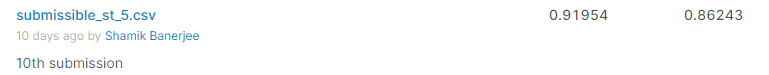

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on only one year of data (1576 to 1941) and predicts 1942 to 1969. 
<br>But for validation it fits on entire data till 1913 and predicts 1914 to 1941.

In [5]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 5

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

In [9]:
# # %%time
# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, _, _
# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)

# # ##########################################################################################################################
# # # Estimated time to run 2 min

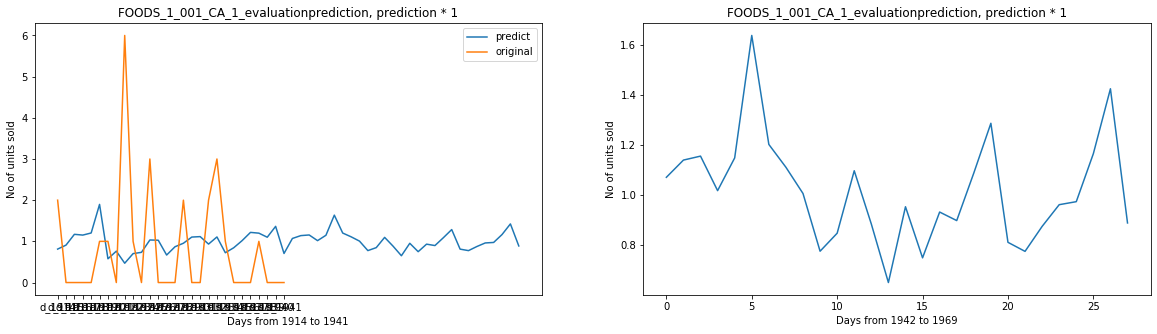

In [8]:
plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy - 3.2

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on only one year of data (1576 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on one year data 1913-365 to 1913.

In [ ]:
# First score is Private and second score is Public score

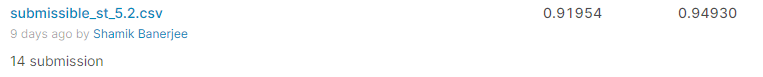

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(1913-365), 3049*1913
strategy =5.2

#### Training Strategy - 3.3

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on three years of data (1941-365-365-365 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on three years data 1913-365-365-365 to 1913.

In [ ]:
# First score is Private and second score is Public score

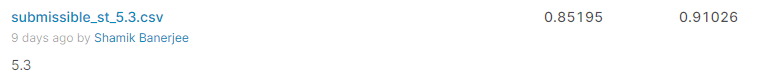

In [5]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365-365-365), 3049*1941, \
                                                                3049*(1913-365-365-365), 3049*1913
strategy = 5.3

CA_1  Done.


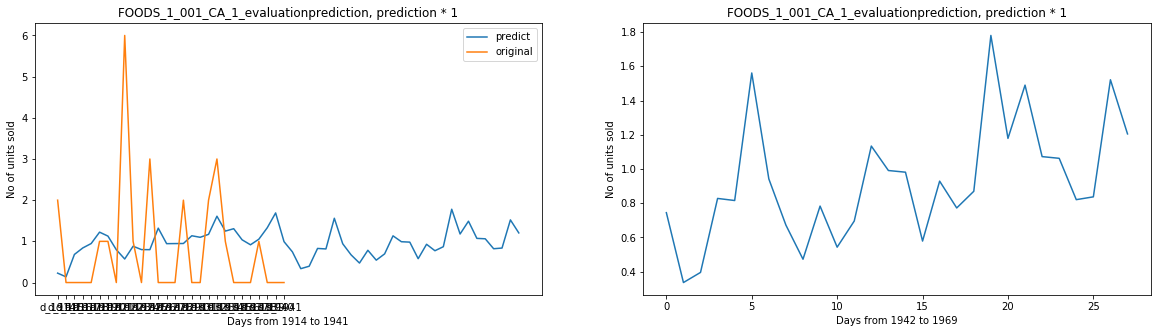

In [6]:
# %%time
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365-365-365), 3049*1913, _, _
le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
out_df = reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy -  3.4

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on entire data (0 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on entire data 0 to 1913.

In [ ]:
# First score is Private and second score is Public score

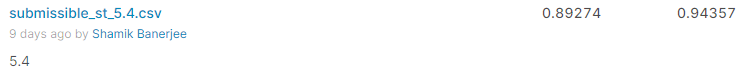

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1941, \
                                                                3049*(0), 3049*1913
strategy = 5.4

CA_1  Done.


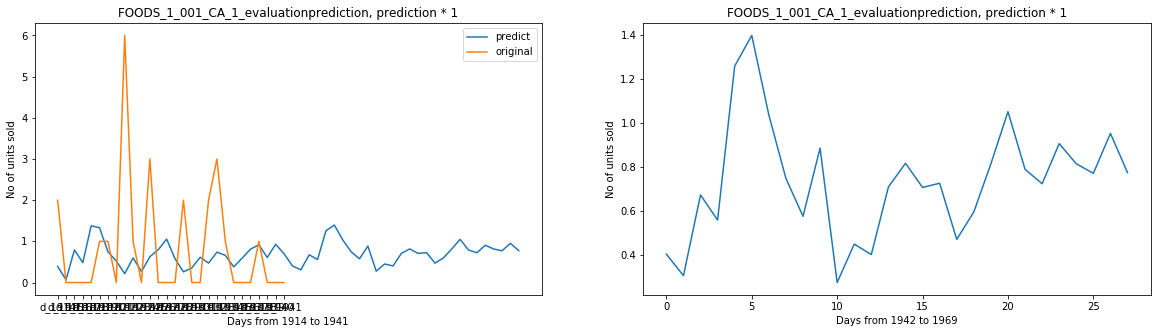

In [7]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1913, _, _
le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
out_df = reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy - 3.5

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on two years data (1941-365-365 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on entire data 0 to 1913.

In [ ]:
# First score is Private and second score is Public score

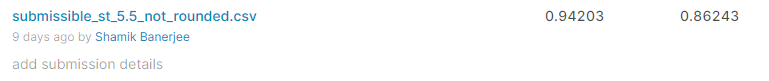

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365-365), 3049*1941, \
                                                                3049*(0), 3049*1913
strategy = 5.5

CA_1  Done.


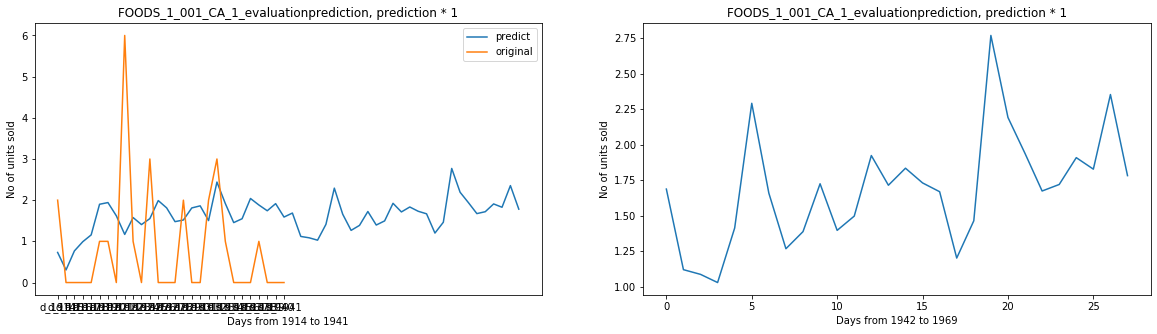

In [8]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365-365), 3049*1913, _, _
le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
out_df = reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

#### Training Strategy - 3.6

This strategy takes only columns added by feature_engineer() function, no more than that.
<br>For evaluation data it fits on three years data (1941-365-365-365 to 1941) and predicts 1942 to 1969. 
<br>For validation again it fits on entire data 0 to 1913.

In [ ]:
# First score is Private and second score is Public score

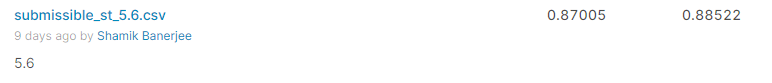

In [ ]:
model = LGBMRegressor(num_leaves=1100, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 1418)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365-365-365), 3049*1941, \
                                                                3049*(0), 3049*1913
strategy = 5.6

CA_1  Done.


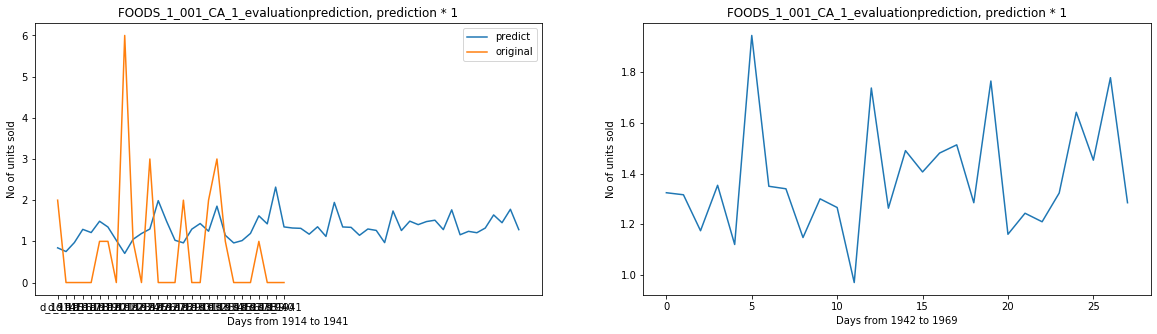

In [9]:
model = LGBMRegressor(num_leaves=1100, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 1418)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365-365-365), 3049*1913, _, _
le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
out_df = reverse_long_form(le, X_test, train_out)

# ##########################################################################################################################
# # Estimated time to run 2 min

plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

### Training strategy 4

#### Training Strategy 4.1

In [ ]:
# First score is Private and second score is Public score

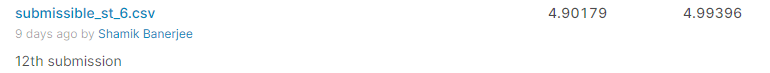

In this strategy we add all the columns we can add. Then we fit on one year of data only, both for eval and val data.
<br>For eval we train on 1941-365 to 1941, we test on 1941 to 1969.
<br>For val we train on 1913-365 to 1913 and we test on 1913 to 1969.

In [10]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(1913-365), 3049*1913
strategy = 6
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # following code can be used to predict on 1913 to 1969 to plot true and predict of 1913 to 1941
        # X_train, y_train = X.iloc[3049*(1941-365-365-365):3049*1913], y[3049*(1941-365-365-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]                     
        
        # Original code for fitting, fitiing only on 3 years data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('Fitting...')
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

In [ ]:
############################## Code for testing MSE of single store for the fit function  ###############################

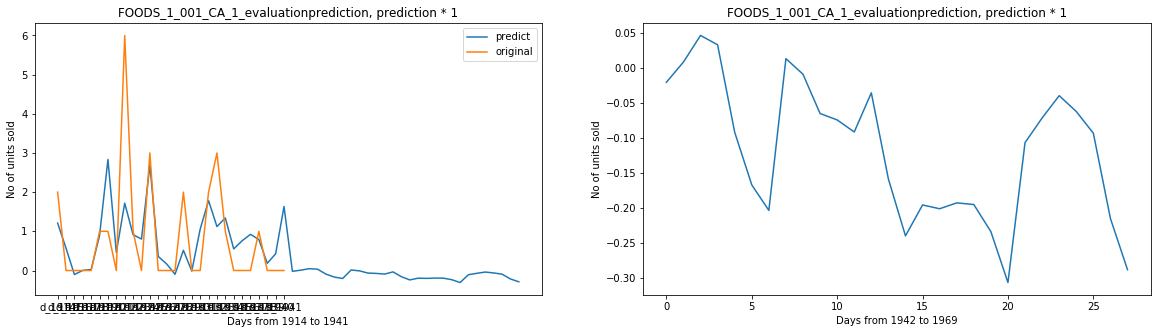

In [12]:
# %%time
# df = sales_train_ev.copy()
# empty_list = [0]*30490
# for i in range(1942, 1970):
#     df['d_'+str(i)] = empty_list
# df = feature_engineer(df)

# model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
# ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1913-365), 3049*1913, 3049*(1913-365), 3049*1913
# strategy = 6

# le, X_test, y_test, train_out = fit_fun_2(df, 'CA_1')
# out_df = reverse_long_form(le, X_test, train_out)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)

##########################################################################################################################
# Estimated time to run 2 min

In [ ]:
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 1.5)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 2)
# plot_prediction(out_df, 'FOODS_1_001_CA_1_evaluation', 2.5)

#### Training Strategy - 4.2

In [ ]:
# First score is Private and second score is Public score

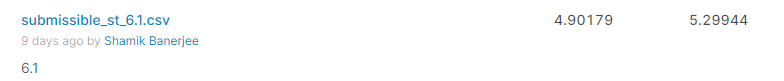

Not plotting the test code as the same eval data is fit here, only change is that entire val data is fit.

In [ ]:
model = LGBMRegressor(num_leaves=588, learning_rate=0.67, reg_lambda=0.78, n_estimators= 363, min_data_in_leaf= 906)
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 6.1
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # following code can be used to predict on 1913 to 1969 to plot true and predict of 1913 to 1941
        # X_train, y_train = X.iloc[3049*(1941-365-365-365):3049*1913], y[3049*(1941-365-365-365):3049*1913]
        # X_test, y_test = X.iloc[3049*1913:], y[3049*1913:]                     
        
        # Original code for fitting, fitiing only on 3 years data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     
    
    if df.id.iloc[0].find('validation') != -1:  # if validation data
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('Fitting...')
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

### Training Strategy 5

#### Training Function for 5.1, 5.2

In [3]:
def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y_withou_adding_more_features(df, store_name)
    
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # X_train, y_train = X.iloc[0:3049*1941], y[:3049*1941]
        # X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if df.id.iloc[0].find('validation') != -1:  # if validation data
        
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

#### Training strategy 5.1

Instead of LGBRegressor we try XGBRegressor. 
We fit one year data for eval and entire data for val.
We dont add more features than added by feature_engineer() function.

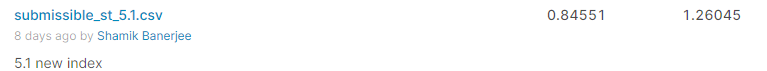

In [9]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(1941-365), 3049*1941, 3049*(0), 3049*1913
strategy = 5.1
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

#### Training strategy 5.2

Instead of LGBRegressor we try XGBRegressor. 
We fit entire data for both eval and val. 
We dont add more features than added by feature_engineer() function.

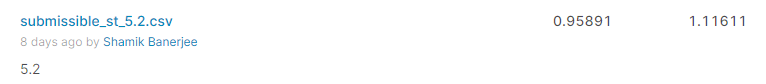

In [4]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1941, 3049*(0), 3049*1913
strategy = 5.2
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

#### Training Strategy - 5.3

Instead of LGBRegressor we try XGBRegressor. 
We fit entire data for both eval and val. 
We all the features we can.

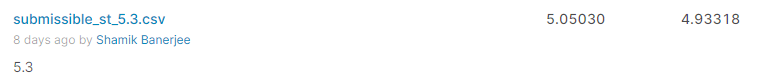

Score - 4.93

In [3]:
ev_train_start, ev_train_end, val_train_start, val_train_end = 3049*(0), 3049*1941, 3049*(0), 3049*1913
strategy = 5.3
model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

def fit_fun_2(df, store_name):
    cclear()
    print('Using strategy ', strategy)
    X, y, le = get_X_and_y(df, store_name)      # this fun selects rows for given store name, adds more columns, 
                                                # does encoding, returns X and y and encoder
     
    if df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # X_train, y_train = X.iloc[0:3049*1941], y[:3049*1941]
        # X_test, y_test = X.iloc[3049*1941:], y[3049*1941:]

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if df.id.iloc[0].find('validation') != -1:  # if validation data
        
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    model.fit(X_train, y_train)
    train_out = model.predict(X_test)
    
    cclear()
    print(store_name, ' Done.')
    
    return le, X_test, y_test, train_out

### Training Strategy 6.1 - Ignore

In [ ]:
# This model could not be run due to lack of compute power, so there is no score attached.

# In this strategy we wanted to fit one LGBM model to entire data. However our computation powers did not permit.
# I found a suggestion of hyperparameters for fitting on entire data from this discussion - 
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164685  under Model 2 section.
    
# As our computer power did not permit I decided to try that same model with same parameters on data separated by dept id.
# We do that below in strategy 7.1.

In [5]:
def get_whole_X_y(new_df):
    print('Using strategy ', strategy)

    new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
    new_df = new_df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
    new_df['date'] = new_df['date'].astype(str)

    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)

    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df
    return le, X, y

In [6]:
def train_on_whole(new_df, X, y):
    ev_train_start, ev_train_end, val_train_start, val_train_end = 10*3049*(0), 10*3049*1941,\
                                                                   10*3049*(0), 10*3049*1913
    model = LGBMRegressor(   boosting_type = 'gbdt', #https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164685
                             objective = 'tweedie',
                             tweedie_variance_power = 1.1,
                             metric = 'rmse',
                             subsample = 0.5,
                             subsample_freq = 1,
                             learning_rate = 0.03,
                             num_leaves = 2047,
                             min_data_in_leaf = 4095,
                             feature_fraction = 0.5,
                             max_bin = 100,
                             n_estimators = 1300,
                             boost_from_average = False,
                             verbose = -1,
                             num_threads = 8)
    print('Getting X_train, y_train...')
    if new_df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if new_df.id.iloc[0].find('validation') != -1:  # if validation data

        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    print('X_train len', len(X_train), 'y_train len', len(y_train), 'X_test len', len(X_test))
    
    print('Fitting model...')
    model.fit(X_train, y_train)
    _ = joblib.dump(model, 'ML6.1.pkl', compress=9)
    print('Fitting done, exiting...')
    return model, X_test

In [7]:
def get_only_X_test(new_df, X, y):
    ev_train_start, ev_train_end, val_train_start, val_train_end = 10*3049*(0), 10*3049*1941,\
                                                                   10*3049*(0), 10*3049*1913
    
    print('Getting X_train, y_train...')
    if new_df.id.iloc[0].find('evaluation') != -1:  # if evaluation data

        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]                     

    if new_df.id.iloc[0].find('validation') != -1:  # if validation data

        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    return X_test

In [ ]:
def make_prediction(model, X_test):
    print('Making predictions...')
    train_out = model.predict(X_test)

    print('Done.')
    return train_out

In [9]:
strategy = 6.1

In [ ]:
########### Train

In [10]:
%%time
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 29 s, sys: 7.76 s, total: 36.8 s
Wall time: 36.8 s


In [11]:
%%time
le, X, y = get_whole_X_y(df)

Using strategy  6.1
Encoding categorical features...
Encoding col:  id
Encoding col:  item_id
Encoding col:  dept_id
Encoding col:  cat_id
Encoding col:  store_id
Encoding col:  state_id
Encoding col:  d
Encoding col:  date
CPU times: user 1min 37s, sys: 19.7 s, total: 1min 57s
Wall time: 1min 57s


In [12]:
len(X), len(y)

(60034810, 60034810)

In [ ]:
%%time
model, X_test = train_on_whole(df, X, y)

Getting X_train, y_train...
X_train len 59181090 y_train len 59181090 X_test len 853720
Fitting model...


In [ ]:
############## Predict

In [ ]:
regg = joblib.load('ML6.1.pkl')

In [ ]:
%%time
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

le, X, y = get_whole_X_y(df)
X_test = get_only_X_test(df, X, y)

In [ ]:
X_test

In [ ]:
%%time
train_out = make_prediction(regg, X_test)

In [ ]:
# def reverse_long_form(le, X_test, train_out):
#     for i in range(len(non_numeric_col_list)):
#         X_test[non_numeric_col_list[i]] = le[i].inverse_transform(X_test[non_numeric_col_list[i]])

#     X_test['unit_sale'] = train_out
#     kk = X_test.pivot(index='id', columns='d')['unit_sale']
#     kk['id'] = kk.index
#     kk.reset_index(drop=True, inplace=True)

#     cols = list(kk)
#     cols = [cols[-1]] + cols[:-1]
#     kk = kk[cols]

#     return kk

# out_df = reverse_long_form(le, X_test, train_out)
# reorder_data(sales_train_val, 'main_out_val')

### Training Strategy 7

#### Training Strategy 7.1

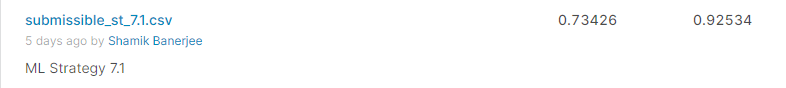

We fit an LGBM model on entire data separated by dept id.

In [3]:
def startegy7dot1(new_df, dept):
    print('Using strategy ', strategy)

    evaluation, validation = new_df.id.iloc[0].find('evaluation'), new_df.id.iloc[0].find('validation')
    new_df = new_df[new_df.dept_id == dept]
    print('Total rows: ', len(new_df))
    
    rows_per_day = len(new_df[new_df.d == 'd_1'])
    print('Rows per day: ', rows_per_day)
    
    new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
    new_df = new_df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
    new_df['date'] = new_df['date'].astype(str)

    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)

    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df
    
    ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                                   rows_per_day*(0), rows_per_day*1913
    model = LGBMRegressor(boosting_type = 'gbdt',  #https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/164685
                          objective = 'tweedie',
                          tweedie_variance_power = 1.1,
                          metric = 'rmse',
                          subsample = 0.5,
                          subsample_freq = 1,
                          learning_rate = 0.03,
                          num_leaves = 2047,
                          min_data_in_leaf = 4095,
                          feature_fraction = 0.5,
                          max_bin = 100,
                          n_estimators = 1300,
                          boost_from_average = False,
                          verbose = -1,
                          num_threads = 8)
    
    if evaluation != -1:  # if evaluation data
        print('Getting X_train, y_train...')
        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
        
    if validation != -1:  # if validation data
        print('Getting X_train, y_train...')
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('X_train len', len(X_train), 'y_train len', len(y_train), 'X_test len', len(X_test))
    
    print('Fitting model...')
    model.fit(X_train, y_train)
    print('Fitting done.')
    
    print('Making predictions...')
    train_out = model.predict(X_test)

    print('Done.')
    return le, X_test, train_out

def get_output_of_eval_or_val(df):
    main_out_df = pd.DataFrame()
    
    list_dept = list(set(df.dept_id))
    for i in list_dept:
        print('Sequence of depts processing: ', list_dept)
        print('Working on Dept: ', i)
        le, X_test, train_out = startegy7dot1(df, i)
        print('Reversing the long form...')
        out_df = reverse_long_form(le, X_test, train_out)
        main_out_df = pd.concat([main_out_df, out_df], ignore_index=False)
        cclear()

    l = []      # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    l = ['id']+l

    main_out_df.columns = l
    
    return main_out_df

In [6]:
strategy = 7.1

In [4]:
%%time

df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 29.7 s, sys: 7.72 s, total: 37.5 s
Wall time: 37.4 s


In [1]:
# le, X_test, train_out = startegy7dot1(df, 'HOBBIES_1')
# out_df = reverse_long_form(le, X_test, train_out)

In [5]:
%%time
main_out_df_ev = get_output_of_eval_or_val(df)
main_out_df_ev.to_csv('main_out_ev.csv')

CPU times: user 8h 10min 54s, sys: 1min 51s, total: 8h 12min 46s
Wall time: 1h 19min 40s


In [ ]:
#### Val Data

In [4]:
%%time
df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 29 s, sys: 7.46 s, total: 36.4 s
Wall time: 36.4 s


In [7]:
%%time
main_out_df_val = get_output_of_eval_or_val(df)
main_out_df_val.to_csv('main_out_val.csv')

CPU times: user 8h 3min 13s, sys: 1min 49s, total: 8h 5min 2s
Wall time: 1h 18min 29s


In [8]:
reorder_data(sales_train_val, 'main_out_val')
reorder_data(sales_train_ev, 'main_out_ev')

In [ ]:
main_out_ev = pd.read_csv('main_out_ev.csv')
main_out_ev = main_out_ev.drop(main_out_ev.columns[0], axis=1)

main_out_val = pd.read_csv('main_out_val.csv')
main_out_val = main_out_val.drop(main_out_val.columns[0], axis=1)

sub_df = pd.concat([main_out_ev, main_out_val], ignore_index=True)
sub_df = sub_df.round(2)

#### Training Strategy 7.2

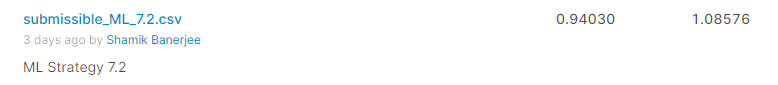

We repeat the 7.1 strategy but this time we do our own hyperparameter tuning so except the model, everything else stays the
same.

In [ ]:
########################### Hyperparameter Tuning on Data for one Dept Id and all years possible. ########################

In [3]:
%%time

df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 35.3 s, sys: 8.17 s, total: 43.5 s
Wall time: 43.4 s


In [4]:
%%time

new_df = df
new_df = new_df[new_df.dept_id == 'HOBBIES_1']
print('Total rows: ', len(new_df))

rows_per_day = len(new_df[new_df.d == 'd_1'])
print('Rows per day: ', rows_per_day)

new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
new_df = new_df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
new_df['date'] = new_df['date'].astype(str)

y = new_df.unit_sale                          # getting the label
new_df = new_df.drop('unit_sale', axis=1)

print('Encoding categorical features...')
le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

X = new_df

ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                               rows_per_day*(0), rows_per_day*1913

print('Getting X_train, y_train...')
# fitiing only on one year data
X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:]

Total rows:  8191040
Rows per day:  4160


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Encoding categorical features...
Encoding col:  id
Encoding col:  item_id
Encoding col:  dept_id
Encoding col:  cat_id
Encoding col:  store_id
Encoding col:  state_id
Encoding col:  d
Encoding col:  date
Getting X_train, y_train...
CPU times: user 28.3 s, sys: 9.9 s, total: 38.2 s
Wall time: 38.1 s


In [5]:
%%time
param_list_to_try = {
            'subsample' : sp_randFloat(0.1, 0.9),
            'learning_rate' : sp_randFloat(0.01, 0.9),
            'num_leaves' : sp_randint(150, 2200),
            'min_data_in_leaf' : sp_randint(100, 5000),
            'reg_lambda' : sp_randFloat(0.1, 0.9),
            'feature_fraction' :sp_randFloat(0.1, 0.9),
            'max_bin' : sp_randint(50, 1000),
            'n_estimators' : sp_randint(100, 2000)}

no_of_hyperparameters = 3
clf = LGBMRegressor(boosting_type = 'gbdt', 
                    objective = 'tweedie', 
                    tweedie_variance_power = 1.1,
                    metric = 'rmse',
                    subsample_freq = 1,
                    boost_from_average = False,
                    verbose = -1,
                    num_threads = 8)

random_search = RandomizedSearchCV( estimator = clf, param_distributions = param_list_to_try,\
                                   n_iter = no_of_hyperparameters\
            ,scoring = make_scorer(mse, greater_is_better = False), cv = 2, refit = True, \
                                   random_state = 314, verbose = True)

random_search.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(random_search.best_score_, random_search.best_params_))

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] feature_fraction is set=0.9251862233436707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251862233436707
[LightGBM] [Warning] min_data_in_leaf is set=1166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1166
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] feature_fraction is set=0.9251862233436707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9251862233436707
[LightGBM] [Warning] min_data_in_leaf is set=1166, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1166
[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] feature_fraction is set=0.945902608593411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459026

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 81.1min finished


[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
[LightGBM] [Warning] feature_fraction is set=0.15064253784566134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15064253784566134
[LightGBM] [Warning] min_data_in_leaf is set=1380, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1380
Best score reached: -4.470092102883158 with params: {'feature_fraction': 0.15064253784566134, 'learning_rate': 0.3071575016251908, 'max_bin': 429, 'min_data_in_leaf': 1380, 'n_estimators': 1515, 'num_leaves': 1743, 'reg_lambda': 0.3888338532144111, 'subsample': 0.613496996394585} 
CPU times: user 10h 14min 3s, sys: 1min 35s, total: 10h 15min 39s
Wall time: 1h 29min 36s


In [ ]:
# Best score reached: -4.470092102883158 with params: 
# {'feature_fraction': 0.15064253784566134, 'learning_rate': 0.3071575016251908, 'max_bin': 429, 'min_data_in_leaf': 1380, 
#  'n_estimators': 1515, 'num_leaves': 1743, 'reg_lambda': 0.3888338532144111, 'subsample': 0.613496996394585}

In [ ]:
########################### Repeating Training Strategy 7.1 with new found best parameters ###############################

In [9]:
def startegy7dot1(new_df, dept):
    print('Using strategy ', strategy)

    evaluation, validation = new_df.id.iloc[0].find('evaluation'), new_df.id.iloc[0].find('validation')
    new_df = new_df[new_df.dept_id == dept]
    print('Total rows: ', len(new_df))
    
    rows_per_day = len(new_df[new_df.d == 'd_1'])
    print('Rows per day: ', rows_per_day)
    
    new_df['day_of_month'] = new_df['day_of_month'].fillna(0)
    new_df = new_df.astype({'day_of_month': 'int32'})      # Making day_of_month column as int
    new_df['date'] = new_df['date'].astype(str)

    y = new_df.unit_sale                          # getting the label
    new_df = new_df.drop('unit_sale', axis=1)

    print('Encoding categorical features...')
    le, new_df = encode_cat_cols(new_df)          # Encoding Categorical Columns

    X = new_df
    
    ev_train_start, ev_train_end, val_train_start, val_train_end = rows_per_day*(0), rows_per_day*1941,\
                                                                   rows_per_day*(0), rows_per_day*1913
    model = LGBMRegressor(boosting_type = 'gbdt',  
                          objective = 'tweedie',
                          tweedie_variance_power = 1.1,
                          metric = 'rmse',
                          subsample = 0.613,
                          subsample_freq = 1,
                          learning_rate = 0.307,
                          num_leaves = 1743,
                          min_data_in_leaf = 1380,
                          feature_fraction = 0.1506,
                          max_bin = 429,
                          n_estimators = 1515,
                          boost_from_average = False,
                          verbose = -1,
                          num_threads = 8,
                          reg_lambda = 0.388)
 
    if evaluation != -1:  # if evaluation data
        print('Getting X_train, y_train...')
        # fitiing only on one year data
        X_train, y_train = X.iloc[ev_train_start:ev_train_end], y[ev_train_start:ev_train_end] 
        X_test, y_test = X.iloc[ev_train_end:], y[ev_train_end:] 
        
    if validation != -1:  # if validation data
        print('Getting X_train, y_train...')
        X_train, y_train = X.iloc[val_train_start:val_train_end], y[val_train_start:val_train_end]
        X_test, y_test = X.iloc[val_train_end:], y[val_train_end:]
    
    print('X_train len', len(X_train), 'y_train len', len(y_train), 'X_test len', len(X_test))
    
    print('Fitting model...')
    model.fit(X_train, y_train)
    print('Fitting done.')
    
    print('Making predictions...')
    train_out = model.predict(X_test)

    print('Done.')
    return le, X_test, train_out

def get_output_of_eval_or_val(df):
    main_out_df = pd.DataFrame()
    
    list_dept = list(set(df.dept_id))
    for i in list_dept:
        print('Sequence of depts processing: ', list_dept)
        print('Working on Dept: ', i)
        le, X_test, train_out = startegy7dot1(df, i)
        print('Reversing the long form...')
        out_df = reverse_long_form(le, X_test, train_out)
        main_out_df = pd.concat([main_out_df, out_df], ignore_index=False)
        cclear()

    l = []      # In this part we rename the columns to F_1, F_2 ....
    for i in range(1,29):
        l.append('F'+str(i))
    l = ['id']+l

    main_out_df.columns = l
    
    return main_out_df

In [10]:
strategy = 7.2

In [7]:
%%time

df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 36.4 s, sys: 7.84 s, total: 44.2 s
Wall time: 44.1 s


In [11]:
%%time
main_out_df_ev = get_output_of_eval_or_val(df)
main_out_df_ev.to_csv('main_out_ev.csv')

CPU times: user 7h 8min 14s, sys: 1min 21s, total: 7h 9min 35s
Wall time: 1h 6min 36s


In [ ]:
#### Val Data

In [12]:
%%time
df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

CPU times: user 36.9 s, sys: 7.93 s, total: 44.8 s
Wall time: 44.7 s


In [13]:
%%time
main_out_df_val = get_output_of_eval_or_val(df)
main_out_df_val.to_csv('main_out_val.csv')

CPU times: user 6h 58min 59s, sys: 1min 17s, total: 7h 17s
Wall time: 1h 5min 4s


In [14]:
reorder_data(sales_train_val, 'main_out_val')
reorder_data(sales_train_ev, 'main_out_ev')

In [15]:
main_out_ev = pd.read_csv('main_out_ev.csv')
main_out_ev = main_out_ev.drop(main_out_ev.columns[0], axis=1)

main_out_val = pd.read_csv('main_out_val.csv')
main_out_val = main_out_val.drop(main_out_val.columns[0], axis=1)

sub_df = pd.concat([main_out_ev, main_out_val], ignore_index=True)
sub_df = sub_df.round(2)

In [17]:
sub_df.to_csv('submissible_ML_7.2.csv', index=False)

In [18]:
pd.read_csv('submissible_ML_7.2.csv')

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_evaluation,0.42,0.40,0.40,0.41,0.41,0.49,0.44,0.36,0.34,...,0.44,0.52,0.47,0.38,0.37,0.37,0.37,0.44,0.52,0.47
1,HOBBIES_1_002_CA_1_evaluation,0.41,0.39,0.39,0.39,0.40,0.47,0.42,0.35,0.33,...,0.42,0.50,0.45,0.37,0.35,0.36,0.36,0.42,0.50,0.45
2,HOBBIES_1_003_CA_1_evaluation,0.15,0.14,0.14,0.14,0.14,0.17,0.15,0.13,0.12,...,0.15,0.18,0.16,0.13,0.13,0.13,0.13,0.15,0.18,0.16
3,HOBBIES_1_004_CA_1_evaluation,3.80,3.63,3.65,3.69,3.72,4.39,3.97,3.27,3.12,...,3.96,4.67,4.22,3.48,3.32,3.34,3.38,3.96,4.67,4.22
4,HOBBIES_1_005_CA_1_evaluation,1.48,1.41,1.42,1.43,1.44,1.70,1.54,1.27,1.21,...,1.54,1.81,1.64,1.35,1.29,1.30,1.31,1.54,1.81,1.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_validation,0.99,0.90,0.89,0.89,1.01,1.22,1.22,0.97,0.89,...,0.99,1.21,1.22,0.97,0.89,0.88,0.88,0.99,1.21,1.26
60976,FOODS_3_824_WI_3_validation,0.47,0.43,0.43,0.43,0.48,0.59,0.59,0.47,0.43,...,0.48,0.58,0.59,0.47,0.43,0.42,0.42,0.48,0.58,0.60
60977,FOODS_3_825_WI_3_validation,0.86,0.78,0.77,0.78,0.87,1.06,1.07,0.85,0.77,...,0.86,1.05,1.07,0.85,0.77,0.76,0.77,0.86,1.05,1.09
60978,FOODS_3_826_WI_3_validation,0.72,0.65,0.64,0.65,0.73,0.89,0.89,0.71,0.65,...,0.72,0.87,0.89,0.71,0.65,0.64,0.64,0.72,0.87,0.91


## Pipeline to train any strategy

In [ ]:
# estimated time (strategy_3.1 - 7 min + 10 min)
# estimated time (strategy_3.2 - 7 min + 7 min)
# estimated time (strategy_3.3 - 8 min + 8 min)
# estimated time (strategy_4.1 - 35 min +  27 min)
# estimated time (strategy_5.1 - 5 min +  16 min)
# estimated time (strategy_5.1 - 36 min +  35 min)
# sequence of stores = CA_1, CA_2, CA_3, CA_4, WI_1, WI_2, WI_3, TX_1, TX_2, TX_3

Training for Evaluation Data

In [4]:
%%time
df = sales_train_ev.copy()
empty_list = [0]*30490
for i in range(1942, 1970):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)

main_out_df = training_function(df)
main_out_df.to_csv('main_out_ev.csv')
reorder_data(sales_train_ev, 'main_out_ev')

TX_3  Done.
CPU times: user 2h 15min 49s, sys: 2min 1s, total: 2h 17min 51s
Wall time: 36min 22s


Training for Validation Data

In [5]:
%%time
df = sales_train_val.copy()
empty_list = [0]*30490
for i in range(1914, 1942):
    df['d_'+str(i)] = empty_list
df = feature_engineer(df)
main_out_df = training_function(df)
main_out_df.to_csv('main_out_val.csv')
reorder_data(sales_train_val, 'main_out_val')

TX_3  Done.
CPU times: user 2h 12min 37s, sys: 2min, total: 2h 14min 37s
Wall time: 35min 22s


Concatenate both CSVs to create the submission csv.

In [6]:
main_out_ev = pd.read_csv('main_out_ev.csv')
main_out_ev = main_out_ev.drop(main_out_ev.columns[0], axis=1)

main_out_val = pd.read_csv('main_out_val.csv')
main_out_val = main_out_val.drop(main_out_val.columns[0], axis=1)

sub_df = pd.concat([main_out_ev, main_out_val], ignore_index=True)
sub_df = sub_df.round(2)                            # We round the float values till 2nd decimal places  

# we only keep absolute values
ll = sub_df['id']
sub_df = sub_df.drop('id', axis=1)
for i in list(sub_df.columns):
    sub_df[i] = sub_df[i].abs()

# sub_df = sub_df.round(0).astype(int)    

# sub_df.select_dtypes(exclude=['object' ]) * 1.5
sub_df['id'] = ll

cols = list(sub_df)
cols = [cols[-1]] + cols[:-1]
sub_df = sub_df[cols]
sub_df
    
sub_df.to_csv('submissible_st_5.3.csv', index = False)

### Submission CSV

In [2]:
# sub_df = pd.read_csv('submissible_st_5.3.csv')
# sub_df